In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
import matplotlib.pyplot as plt
from scipy.io.matlab import loadmat, savemat
from sklearn.model_selection import train_test_split

c:\Users\zhuang\AppData\Local\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Load dataset

In [36]:
paired_dir = 'data/'
batch_size = 100

image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=paired_dir, transform=image_transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [27]:
classes = dataset.find_classes(paired_dir)[0]
classes

['alignBottom', 'alignLeft', 'alignRight', 'alignTop']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


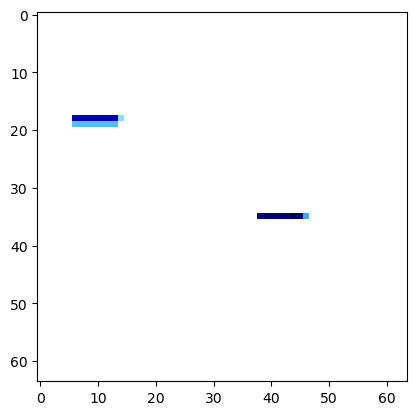

In [28]:
image = dataset[10][0]
image = image.permute(1, 2, 0)
plt.imshow(image.numpy())

# Model

In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [30]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(3136, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [31]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [33]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [34]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Learning phase

In [41]:
epochs = 20

for i in range(5):
    model = LeNet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print("CrossValidation : "+str(i)+"\n-------------------------------\n")
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


    # Create the data loaders for training and validation
    train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=200,
        shuffle=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=200,
        shuffle=False
    )
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        #test(test_dataloader, model, loss_fn)
        test(test_dataloader, model, loss_fn)
    
    # save model
    torch.save(model.state_dict(), f"./models/model{i}")

    print("Done!")

CrossValidation : 0
-------------------------------

Epoch 1
-------------------------------
loss: 1.381596  [  200/ 4000]
Test Error: 
 Accuracy: 59.1%, Avg loss: 0.980365 

Epoch 2
-------------------------------
loss: 0.895271  [  200/ 4000]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.616392 

Epoch 3
-------------------------------
loss: 0.600355  [  200/ 4000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.494176 

Epoch 4
-------------------------------
loss: 0.542916  [  200/ 4000]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.488858 

Epoch 5
-------------------------------
loss: 0.439538  [  200/ 4000]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.411773 

Epoch 6
-------------------------------
loss: 0.433640  [  200/ 4000]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.346324 

Epoch 7
-------------------------------
loss: 0.327025  [  200/ 4000]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.331206 

Epoch 8
-------------------------------
loss: 0.287641  [  200/ 4000]
Test Error: 
 Accuracy:

# Evaluation

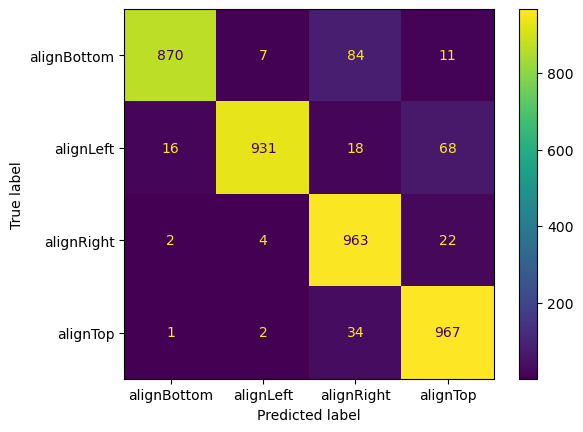

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in train_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_pred.extend(pred.argmax(1).data.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = classes)
disp.plot()
plt.show()

Accuracy avant:  0.81375
Accuracy avant:  0.9961089494163424
pred restantes:  257
pred supprimees:  543
pourcentage restant:  0.32125


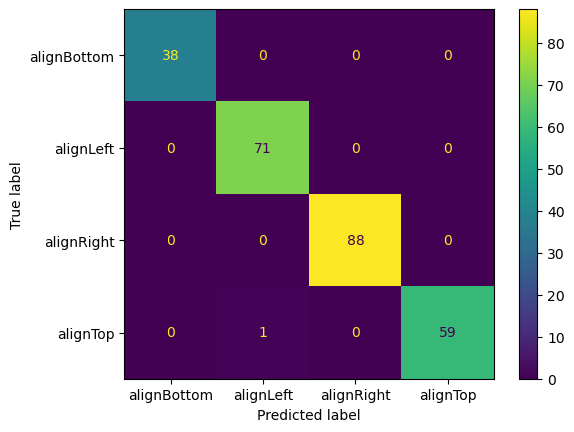

In [96]:
import numpy as np
#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in train_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.90
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = classes)
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))


plt.show()



In [2]:
# save model
torch.save(model.state_dict(), "./models/model")

NameError: name 'model' is not defined

# Load Model

In [8]:
model = LeNet()
model.load_state_dict(torch.load("models/model"))

<All keys matched successfully>

In [2]:
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [10]:
from PIL import Image
import numpy as np

In [9]:
image = np.ones((1280,480,3)).astype(np.uint8)
image = Image.fromarray(image)
x = image_transform(image).reshape((1,3,64,64))
print(x.shape)
model(x)

NameError: name 'np' is not defined

In [11]:
paired_dir = 'data/'
batch_size = 100

image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=paired_dir, transform=image_transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


Dataset ImageFolder
    Number of datapoints: 1000
    Root location: data/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [21]:
y_true = []
y_pred = []
X1 = []

for X, y in train_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    X1.extend(X.data.cpu().numpy())

X1 = np.array(X1)
X1 = X1.transpose((0,2,3,1))
y_pred = np.array(y_pred)
y_true = np.array(y_true)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


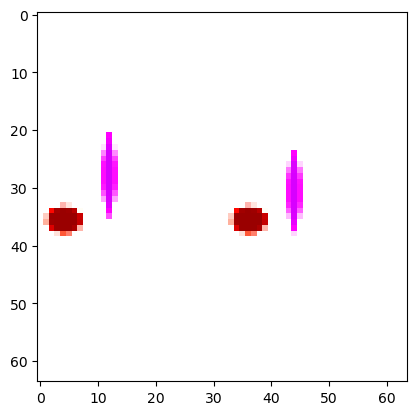

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


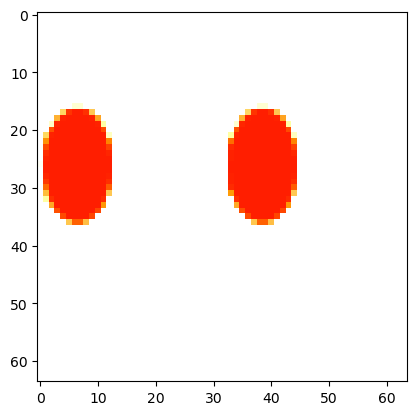

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


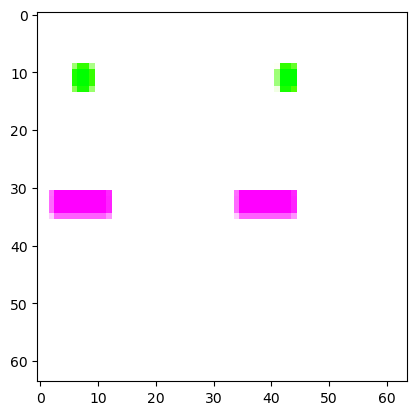

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


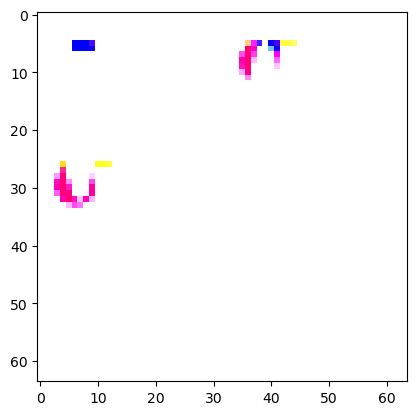

In [24]:
for y in range(4):
    i = np.where(y_true == y)[0][0]
    print(y)
    plt.imshow(X1[i])
    plt.show()